In [15]:
import os
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv(find_dotenv())

api_key = os.environ.get("OPENAI_API_KEY")

llm = ChatOpenAI(model = "gpt-4o",api_key = api_key)
embeddings = OpenAIEmbeddings(model = "text-embedding-ada-002",api_key=api_key)

In [16]:
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-28317647-8fad-43f5-a188-3437ccc71a2a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
from typing import Annotated, Dict, List
from typing_extensions import TypedDict,List,Optional
from pydantic import BaseModel, Field
# from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ToolMessage, AIMessage
import os
import pandas as pd
import numpy as np
import joblib

In [36]:
class LoanParameters(BaseModel):
    Gender: str
    Married: str
    Dependents: str
    Education: str
    Self_Employed: str
    LoanAmount: float
    Loan_Amount_Term: float
    Credit_History: float
    Property_Area: str
    TotalIncome: float

class DocumentStatus(BaseModel):
    id_proof: bool = False
    address_proof: bool = False
    income_proof: bool = False
    property_documents: bool = False
    bank_statements: bool = False

class LoanApplicationDetails(BaseModel):
    loan_type: Optional[str] = None
    loan_purpose: Optional[str] = None
    collateral_details: Optional[str] = None
    preferred_bank: Optional[str] = None
    preferred_tenure: Optional[int] = None

class AgentState(BaseModel):
    user_query: str
    messages: List = Field(default_factory=list)
    task_type: Optional[str] = None
    loan_parameters: Optional[LoanParameters] = None
    eligibility_result: Optional[str] = None
    form_submitted: bool = False
    eligibility_checked: bool = False
    documents_uploaded: Optional[DocumentStatus] = None
    documents_validated: bool = False
    application_details: Optional[LoanApplicationDetails] = None
    application_details_submitted: bool = False
    template_form_filled: bool = False
    bank_form_filled: bool = False
    guidance_stage: Optional[str] = "initial"

class QueryOutput(BaseModel):
    """Inputs to the Loan Guidance Tool"""
    task_type: str = Field(description = "Type of task to perform based on user_query")

### Process User Query

In [37]:
def process_user_query(state: AgentState):
    print("Processing User Query")
    ASSISTANT_PROMPT = """
        You are an expert in managing Loan applications for users and resolving queries of users regarding the same. You are provided with a user_query
        and your task is to go through the query and return the type of task that user wants.
        <Instructions>
            1. Go through the user_query and extract all the relevant key details from the query.
            2. There are three kinds of tasks that can be performed from the query:
                a. 'Loan Eligibility Check' - User would like to check if he/she is eligible for loan.
                b. 'Loan Application Guidance' - User is looking for guidance on how to proceed with his/her Loan Application.
                c. 'Financial Advise' - User is looking for personalized financial advise based on his/her needs.
            3. Only Output the type of task that user wants and no need for any explanation.
        </Instructions>

        <Input>Query:{query}</Input>
    """
    prompt = ChatPromptTemplate.from_template(ASSISTANT_PROMPT)
    user_chain = prompt | llm.with_structured_output(QueryOutput)
    data = user_chain.invoke({"query": state.user_query})
    print(f"Detected task type: {data.task_type}")
    
    # Add an AI message to the conversation
    new_message = AIMessage(content=f"Based on your query, I understand you need: {data.task_type}. Let's proceed with that.")
    state.messages.append(new_message)
    
    # Update state
    state.task_type = data.task_type
    
    # If this is an eligibility check, inform the user about the form
    if state.task_type == "Loan Eligibility Check":
        form_message = AIMessage(content="To check your loan eligibility, please fill out the loan application form with all the required information.")
        state.messages.append(form_message)
    
    return state

### Loan Eligibility Check

In [38]:
# Function to process form submission for loan eligibility
def process_form_submission(state: AgentState):
    print("Processing form submission")
    
    # If we've already processed a form in this flow, don't do it again
    if hasattr(state, '_form_processed') and state._form_processed:
        return state
    
    # Mark that we've processed a form
    state._form_processed = True
    
    # In a real application, we'd get this from a form submission
    # For now, we'll use a sample dict
    sample_form_data = {
        'Gender': 'Male',
        'Married': 'Yes',
        'Dependents': '1',
        'Education': 'Graduate',
        'Self_Employed': 'No',
        'LoanAmount': 250000.0,
        'Loan_Amount_Term': 360.0,
        'Credit_History': 1.0,
        'Property_Area': 'Urban',
        'TotalIncome': 60000.0
    }
    
    # Create LoanParameters object from form data
    state.loan_parameters = LoanParameters(**sample_form_data)
    state.form_submitted = True
    
    # Add a confirmation message
    confirm_message = AIMessage(content="Thank you for submitting your information. I'll now check your loan eligibility.")
    state.messages.append(confirm_message)
    
    return state


In [39]:
# Function to check loan eligibility using the ML model
def predict_loan_eligibility(state: AgentState):
    print("Predicting loan eligibility")
    
    # If we've already predicted eligibility in this flow, don't do it again
    if state.eligibility_result is not None:
        return state
        
    # Convert parameters to the format needed for prediction
    expected_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                         'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'TotalIncome']
    
    # Prepare input for the model
    sample_input = state.loan_parameters.model_dump()
    
    # Convert to DataFrame
    user_df = pd.DataFrame([sample_input])
    
    # Reorder columns to match training data
    user_df = user_df[expected_features]
    
    try:
        # Load category mappings and encode categorical features
        category_mappings = joblib.load('category_mappings.pkl')
        for col, mapping in category_mappings.items():
            if col in user_df.columns:
                user_df[col] = user_df[col].map(mapping).fillna(-1)  # Assign -1 for unseen values
        
        # Load scaler and transform input
        loaded_scaler = joblib.load('scaler.pkl')
        user_scaled = loaded_scaler.transform(user_df)
        
        # Load Model & Predict
        loaded_model = joblib.load('best_loan_model.pkl')
        prediction = loaded_model.predict(user_scaled)
        
        result = 'Eligible' if prediction[0] == 1 else 'Not Eligible'
        
        # Update state with prediction result
        state.eligibility_result = result
        
    except Exception as e:
        # Handle any errors in prediction
        print(f"Error during prediction: {e}")
        state.eligibility_result = "Error during prediction"
    
    # Create response message
    response_message = None
    if state.eligibility_result == 'Eligible':
        response_message = AIMessage(content=f"""
Congratulations! Based on the information you've provided, you are eligible for the loan. 

Here's a summary of your application:
- Loan Amount: ${state.loan_parameters.LoanAmount:,.2f}
- Loan Term: {int(state.loan_parameters.Loan_Amount_Term)} months
- Credit History: {'Good' if state.loan_parameters.Credit_History == 1.0 else 'Limited'}
- Total Income: ${state.loan_parameters.TotalIncome:,.2f}

Would you like guidance on how to proceed with your application?
        """)
    elif state.eligibility_result == 'Not Eligible':
        response_message = AIMessage(content=f"""
Based on the information you've provided, you may not be eligible for the loan under our standard criteria.

Here are some factors that may have affected your eligibility:
- Loan amount too high relative to income
- Credit history concerns
- Loan term duration
- Employment status

Would you like to discuss alternatives or ways to improve your eligibility?
        """)
    else:
        response_message = AIMessage(content=f"I encountered an issue while processing your eligibility. Please try submitting the form again or contact our support team for assistance.")
    
    state.messages.append(response_message)
    state.eligibility_checked = True
    
    # If this was part of loan guidance, set the right stage for next step
    if state.task_type == "Loan Application Guidance" and state.guidance_stage == "need_eligibility_check":
        state.guidance_stage = "need_documents"
    
    return state

In [40]:
# Function for financial advice
def financial_advice(state: AgentState):
    print("Providing financial advice")
    
    advice_prompt = """
        Provide personalized financial advice based on the user's query. 
        Focus on practical, actionable steps they can take.
        
        <UserQuery>{query}</UserQuery>
    """
    
    prompt = ChatPromptTemplate.from_template(advice_prompt)
    advice = llm.invoke(prompt.invoke({"query": state.user_query})).content
    
    advice_message = AIMessage(content=advice)
    state.messages.append(advice_message)
    
    return state


### Loan Guidance

In [41]:
# Function to check if loan eligibility check has been done
def check_loan_eligibility_status(state: AgentState):
    print("Checking loan eligibility status")
    
    # Prevent recursion by checking if we've been here before in this flow
    if hasattr(state, '_eligibility_check_visited') and state._eligibility_check_visited:
        # Skip to documents if we've already tried to check eligibility
        docs_message = AIMessage(content="""
To proceed with your loan application, we need you to upload the following documents:

1. ID Proof (Passport, Driver's License, or Government ID)
2. Address Proof (Utility bill, Rental agreement)
3. Income Proof (Pay stubs, Tax returns, Employment verification)
4. Property Documents (if applicable for your loan type)
5. Bank Statements (last 6 months)

Please upload these documents to continue with the application process.
        """)
        state.messages.append(docs_message)
        state.guidance_stage = "need_documents"
        
        # Initialize document status
        state.documents_uploaded = DocumentStatus()
        return state
    
    # Mark that we've visited this node
    state._eligibility_check_visited = True
    
    if not state.eligibility_checked and state.eligibility_result is None:
        # Need to perform eligibility check first
        eligibility_message = AIMessage(content="Before proceeding with your loan application, we need to check your eligibility. Please provide your details for the eligibility check.")
        state.messages.append(eligibility_message)
        state.guidance_stage = "need_eligibility_check"
    else:
        # Eligibility check has been done, proceed to document upload
        docs_message = AIMessage(content="""
To proceed with your loan application, we need you to upload the following documents:

1. ID Proof (Passport, Driver's License, or Government ID)
2. Address Proof (Utility bill, Rental agreement)
3. Income Proof (Pay stubs, Tax returns, Employment verification)
4. Property Documents (if applicable for your loan type)
5. Bank Statements (last 6 months)

Please upload these documents to continue with the application process.
        """)
        state.messages.append(docs_message)
        state.guidance_stage = "need_documents"
        
        # Initialize document status
        state.documents_uploaded = DocumentStatus()
    
    return state


def validate_documents(state: AgentState):
    print("Validating documents")
    
    # Simulate document upload
    if state.documents_uploaded is None:
        state.documents_uploaded = DocumentStatus()
    
    # Simulate document validation
    # In a real application, you would verify each document
    state.documents_uploaded.id_proof = True
    state.documents_uploaded.address_proof = True
    state.documents_uploaded.income_proof = True
    state.documents_uploaded.property_documents = True
    state.documents_uploaded.bank_statements = True
    
    state.documents_validated = True
    
    # Send confirmation message
    validation_message = AIMessage(content="""
        Thank you! All your documents have been received and validated:

        ✅ ID Proof
        ✅ Address Proof
        ✅ Income Proof
        ✅ Property Documents
        ✅ Bank Statements

        Now, let's gather some additional details about your loan application.
        """)
    state.messages.append(validation_message)
    state.guidance_stage = "need_application_details"
    
    return state


In [42]:
def form_validation(state: AgentState):
    print("Validating application details form")
    
    # Simulate form submission
    # In a real application, you would get this from a form
    sample_application_details = {
        "loan_type": "Home Loan",
        "loan_purpose": "Purchase of primary residence",
        "collateral_details": "Property at 123 Main St, valued at $350,000",
        "preferred_bank": "First National Bank",
        "preferred_tenure": 30
    }
    
    state.application_details = LoanApplicationDetails(**sample_application_details)
    state.application_details_submitted = True
    
    # Send confirmation message
    confirmation_message = AIMessage(content=f"""
        Thank you for providing the additional details for your loan application:

        - Loan Type: {state.application_details.loan_type}
        - Purpose: {state.application_details.loan_purpose}
        - Collateral: {state.application_details.collateral_details}
        - Preferred Bank: {state.application_details.preferred_bank}
        - Preferred Tenure: {state.application_details.preferred_tenure} years

        I can help you with either of the following options:
        1. Fill a general template form that can be used for any bank
        2. Create a bank-specific form for {state.application_details.preferred_bank}

        Which option would you prefer?
    """)
    state.messages.append(confirmation_message)
    state.guidance_stage = "form_choice"
    
    return state

def process_form_choice(state: AgentState):
    print("Processing form choice")
    
    # Get the last user message
    user_messages = [msg for msg in state.messages if isinstance(msg, HumanMessage)]
    if user_messages:
        last_user_message = user_messages[-1].content.lower()
        
        # Check if user wants template form or bank form
        if "template" in last_user_message or "general" in last_user_message or "1" in last_user_message:
            state.guidance_stage = "selected_template_form"
            choice_message = AIMessage(content="I'll prepare a general template form that can be used with any bank.")
            state.messages.append(choice_message)
        else:
            state.guidance_stage = "selected_bank_form"
            choice_message = AIMessage(content=f"I'll prepare a form specifically for {state.application_details.preferred_bank}.")
            state.messages.append(choice_message)
    else:
        # Default to template form if no user message
        state.guidance_stage = "selected_template_form"
    
    return state


In [43]:
def fill_template_form(state: AgentState):
    print("Filling template form")
    
    # In a real application, you would generate an actual form
    # For now, we'll simulate completion
    state.template_form_filled = True
    
    template_message = AIMessage(content=f"""
        I've prepared a template application form with all your information:

        # LOAN APPLICATION FORM

        ## Applicant Information
        - Name: [From your ID]
        - Address: [From your address proof]
        - Contact: [From your documents]
        - Employment: {state.loan_parameters.Self_Employed}
        - Income: ${state.loan_parameters.TotalIncome:,.2f}

        ## Loan Details
        - Type: {state.application_details.loan_type}
        - Amount: ${state.loan_parameters.LoanAmount:,.2f}
        - Purpose: {state.application_details.loan_purpose}
        - Term: {state.loan_parameters.Loan_Amount_Term} months
        - Collateral: {state.application_details.collateral_details}
        ## Bank Preference
        - Bank: {state.application_details.preferred_bank}
        This general template form is ready for submission to any bank of your choice. You may need to adjust some fields depending on the specific requirements of your chosen bank.
        Your loan application process is now complete. Is there anything else you would like help with?
    """)
    state.messages.append(template_message)
    state.guidance_stage = "completed"
    
    return state

def fill_bank_form(state: AgentState):
    print("Filling bank-specific form")
    
    # In a real application, you would generate a bank-specific form
    # For now, we'll simulate completion
    state.bank_form_filled = True
    
    bank_form_message = AIMessage(content=f"""
        I've prepared the {state.application_details.preferred_bank} specific loan application form:

        # {state.application_details.preferred_bank.upper()} LOAN APPLICATION

        ## Application ID: FNB-{np.random.randint(10000, 99999)}

        ## Applicant Details
        - Full Name: [From your ID]
        - SSN/Tax ID: xxx-xx-xxxx
        - Current Address: [From your address proof]
        - Phone: [From your records]
        - Email: [From your records]

        ## Employment Information
        - Employer: [From income proof]
        - Position: [From income proof]
        - Employment Status: {"Self-Employed" if state.loan_parameters.Self_Employed == "Yes" else "Employed"}
        - Annual Income: ${state.loan_parameters.TotalIncome:,.2f}

        ## Loan Request
        - Loan Type: {state.application_details.loan_type}
        - Loan Amount: ${state.loan_parameters.LoanAmount:,.2f}
        - Loan Purpose: {state.application_details.loan_purpose}
        - Loan Term: {int(state.loan_parameters.Loan_Amount_Term/12)} years
        - Collateral: {state.application_details.collateral_details}

        ## Credit Information
        - Credit Score: {"Excellent" if state.loan_parameters.Credit_History == 1.0 else "Limited"}

        ## Declaration
        - The undersigned certifies that all information provided is true and correct.
        - The applicant authorizes {state.application_details.preferred_bank} to verify all information.

        ## Next Steps:
        1. Please review the form for accuracy
        2. Sign where indicated at the bottom
        3. Submit the form along with all supporting documents to your nearest {state.application_details.preferred_bank} branch
        4. A loan officer will contact you within 3 business days

        Your application is now ready for submission. Is there anything else you'd like me to help you with?
            """)
    state.messages.append(bank_form_message)
    state.guidance_stage = "completed"
    
    return state

In [44]:
# Main function for loan application guidance
def loan_application_guidance(state: AgentState):
    print("Initializing loan application guidance")
    
    # Prevent potential recursion
    if hasattr(state, '_guidance_initialized') and state._guidance_initialized:
        return state
    
    # Mark that we've initialized guidance
    state._guidance_initialized = True
    
    # Set initial guidance stage if not set
    if state.guidance_stage == "initial":
        guidance_intro = AIMessage(content="""
            I'll guide you through the loan application process step by step. The process involves:

            1. Checking your loan eligibility
            2. Uploading and validating required documents
            3. Collecting additional application details
            4. Preparing application forms
            5. Submitting to your preferred bank

            Let's start by checking your loan eligibility status.
        """)
        state.messages.append(guidance_intro)
        state.guidance_stage = "checking_eligibility"
    
    return state

### Build the Graph

In [45]:
# graph_builder = StateGraph(AgentState)
# #Nodes
# graph_builder.add_node("process_user_query",process_user_query)
# #Edges
# graph_builder.add_edge(START,"process_user_query")
# graph_builder.add_edge("process_user_query",END)
# graph = graph_builder.compile()

# Build the graph
def create_loan_agent_graph():
    # Create graph builder
    graph_builder = StateGraph(AgentState)
    
    # Add nodes
    graph_builder.add_node("process_user_query", process_user_query)
    graph_builder.add_node("process_form", process_form_submission)
    graph_builder.add_node("eligibility_check", predict_loan_eligibility)
    graph_builder.add_node("loan_guidance", loan_application_guidance)
    graph_builder.add_node("financial_advice", financial_advice)
    
    # Add loan guidance flow nodes
    graph_builder.add_node("check_eligibility_status", check_loan_eligibility_status)
    graph_builder.add_node("validate_documents", validate_documents)
    graph_builder.add_node("form_validation", form_validation)
    graph_builder.add_node("process_form_choice", process_form_choice)
    graph_builder.add_node("fill_template_form", fill_template_form)
    graph_builder.add_node("fill_bank_form", fill_bank_form)
    
    # Define conditional routing based on task type
    def route_by_task(state: AgentState):
        if state.task_type == "Loan Eligibility Check":
            return "process_form"
        elif state.task_type == "Loan Application Guidance":
            return "loan_guidance"
        elif state.task_type == "Financial Advise":
            return "financial_advice"
        else:
            # Default fallback
            return "loan_guidance"
    
    # Define guidance flow routing - FIXED to prevent recursion
    def route_guidance_flow(state: AgentState):
        print(f"Current guidance stage: {state.guidance_stage}")
        
        if state.guidance_stage == "checking_eligibility":
            return "check_eligibility_status"
        elif state.guidance_stage == "need_eligibility_check":
            # Break potential recursion - go directly to form
            return "process_form"
        elif state.guidance_stage == "need_documents":
            return "validate_documents"
        elif state.guidance_stage == "need_application_details":
            return "form_validation"
        elif state.guidance_stage == "form_choice":
            return "process_form_choice"
        elif state.guidance_stage == "selected_template_form":
            return "fill_template_form"
        elif state.guidance_stage == "selected_bank_form":
            return "fill_bank_form"
        elif state.guidance_stage == "completed":
            return END
        else:
            # Default end
            return END
    
    # Add edges
    graph_builder.add_edge(START, "process_user_query")
    graph_builder.add_conditional_edges(
        "process_user_query",
        route_by_task,
        {
            "process_form": "process_form",
            "loan_guidance": "loan_guidance",
            "financial_advice": "financial_advice"
        }
    )
    
    # Eligibility check path
    graph_builder.add_edge("process_form", "eligibility_check")
    
    # After eligibility check, route appropriately
    def post_eligibility_route(state: AgentState):
        # Break the recursion - always end if we were doing an eligibility check
        if state.task_type == "Loan Eligibility Check":
            return END
            
        # For guidance flow, continue with guidance
        if state.task_type == "Loan Application Guidance":
            # Make sure we don't loop back to eligibility check
            if state.guidance_stage == "need_eligibility_check":
                state.guidance_stage = "need_documents"
            return "loan_guidance"
        
        # Default
        return END
    
    graph_builder.add_conditional_edges(
        "eligibility_check",
        post_eligibility_route,
        {
            "loan_guidance": "loan_guidance",
            END: END
        }
    )
    
    # Loan guidance flow
    graph_builder.add_conditional_edges(
        "loan_guidance",
        route_guidance_flow,
        {
            "check_eligibility_status": "check_eligibility_status",
            "process_form": "process_form",
            "validate_documents": "validate_documents",
            "form_validation": "form_validation",
            "fill_template_form": "fill_template_form",
            "fill_bank_form": "fill_bank_form",
            END: END
        }
    )
    
    # Connect loan guidance steps
    graph_builder.add_conditional_edges(
        "check_eligibility_status",
        route_guidance_flow,
        {
            "process_form": "process_form",
            "validate_documents": "validate_documents"
        }
    )
    
    graph_builder.add_edge("validate_documents", "form_validation")
    graph_builder.add_edge("form_validation", "process_form_choice")
    
    # Add conditional routing for form choice
    graph_builder.add_conditional_edges(
        "process_form_choice",
        lambda state: "fill_template_form" if state.guidance_stage == "selected_template_form" else "fill_bank_form",
        {
            "fill_template_form": "fill_template_form",
            "fill_bank_form": "fill_bank_form"
        }
    )
    
    # Complete either path
    graph_builder.add_edge("fill_template_form", END)
    graph_builder.add_edge("fill_bank_form", END)
    
    # Financial advice path
    graph_builder.add_edge("financial_advice", END)
    
    # Compile the graph
    return graph_builder.compile()

In [46]:
loan_agent_graph = create_loan_agent_graph()

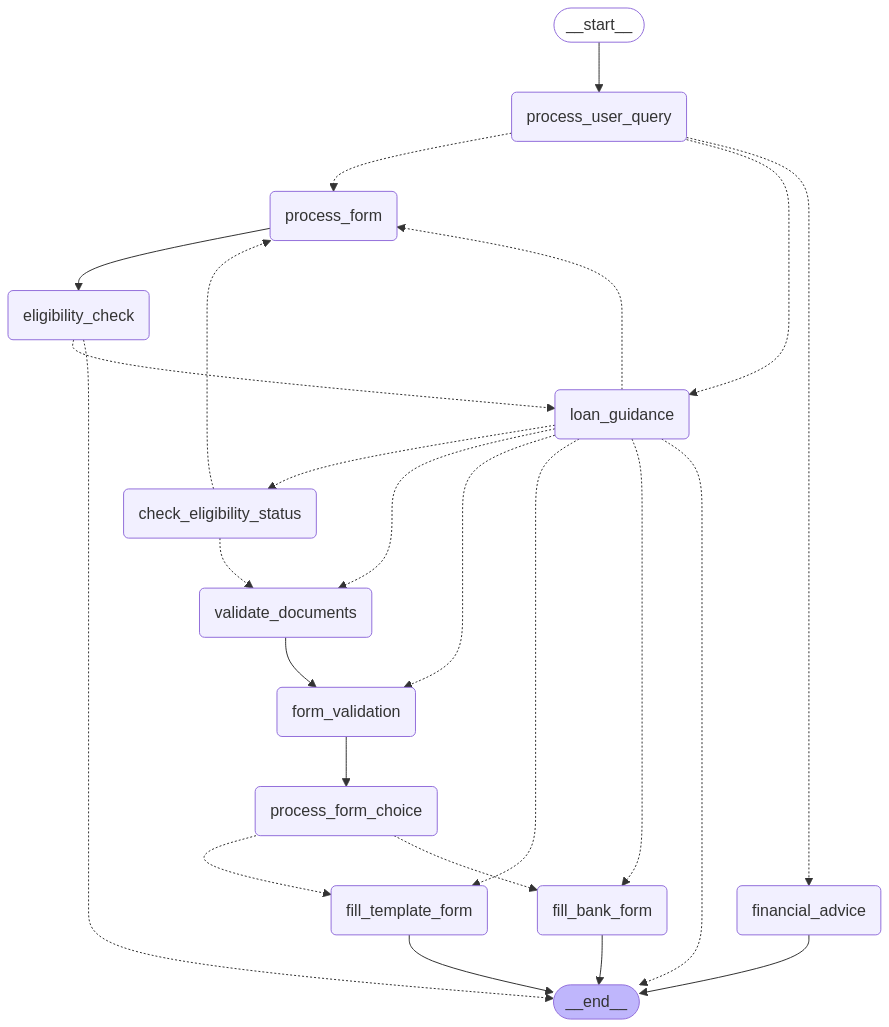

In [47]:
from IPython.display import Image, display

try:
    display(Image(loan_agent_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [48]:
config = {"configurable": {"thread_id":1}}
result = loan_agent_graph.invoke({"user_query":"I earn $60,000 annually with a credit score of 710. Would I qualify for a home loan of $250,000?"},config)

Processing User Query
Detected task type: Loan Eligibility Check
Processing form submission
Predicting loan eligibility


In [49]:
result

{'user_query': 'I earn $60,000 annually with a credit score of 710. Would I qualify for a home loan of $250,000?',
 'task_type': 'Loan Eligibility Check',
 'loan_parameters': LoanParameters(Gender='Male', Married='Yes', Dependents='1', Education='Graduate', Self_Employed='No', LoanAmount=250000.0, Loan_Amount_Term=360.0, Credit_History=1.0, Property_Area='Urban', TotalIncome=60000.0),
 'eligibility_result': 'Not Eligible',
 'form_submitted': True,
 'eligibility_checked': True}

In [50]:
result = loan_agent_graph.invoke(
    {
    "user_query":"I want to apply for a home loan to buy a house in San Francisco. My budget is around $800,000. Can you guide me through the process?"
    },
    config
)

Processing User Query
Detected task type: Loan Application Guidance
Initializing loan application guidance
Current guidance stage: checking_eligibility
Checking loan eligibility status
Current guidance stage: need_eligibility_check
Processing form submission
Predicting loan eligibility
Initializing loan application guidance
Current guidance stage: need_documents
Validating documents
Validating application details form
Processing form choice
Filling template form


In [52]:
result['application_details']

LoanApplicationDetails(loan_type='Home Loan', loan_purpose='Purchase of primary residence', collateral_details='Property at 123 Main St, valued at $350,000', preferred_bank='First National Bank', preferred_tenure=30)